In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models ,Model
import matplotlib.pyplot as plt
import random

import tensorflow.keras.backend as K

In [2]:
#function to normalize to normalize the gradients 
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),name='cov_1'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',name='cov_2'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',name='cov_3'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images=train_images[0:100]
train_labels=train_labels[0:100]
test_images=test_images[0:100]
test_labels=test_labels[0:100]
print(train_images.shape)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_images, train_labels,batch_size=5, epochs=10, validation_data=(test_images, test_labels))


(100, 32, 32, 3)
Epoch 1/10
20/20 [==============================] - 1s 37ms/step - loss: 2.3055 - accuracy: 0.0806 - val_loss: 2.4165 - val_accuracy: 0.0600
Epoch 2/10
20/20 [==============================] - 0s 16ms/step - loss: 2.2598 - accuracy: 0.2235 - val_loss: 2.3698 - val_accuracy: 0.0600
Epoch 3/10
20/20 [==============================] - 0s 17ms/step - loss: 2.1965 - accuracy: 0.2418 - val_loss: 2.4377 - val_accuracy: 0.1300
Epoch 4/10
20/20 [==============================] - 0s 16ms/step - loss: 2.1811 - accuracy: 0.2327 - val_loss: 2.3965 - val_accuracy: 0.0600
Epoch 5/10
20/20 [==============================] - 0s 16ms/step - loss: 2.1370 - accuracy: 0.1065 - val_loss: 2.4675 - val_accuracy: 0.1000
Epoch 6/10
20/20 [==============================] - 0s 16ms/step - loss: 2.0345 - accuracy: 0.2409 - val_loss: 2.3779 - val_accuracy: 0.1200
Epoch 7/10
20/20 [==============================] - 0s 17ms/step - loss: 2.0526 - accuracy: 0.3186 - val_loss: 2.5510 - val_accuracy: 0.0

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cov_1 (Conv2D)               (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
cov_2 (Conv2D)               (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
cov_3 (Conv2D)               (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_11 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)              

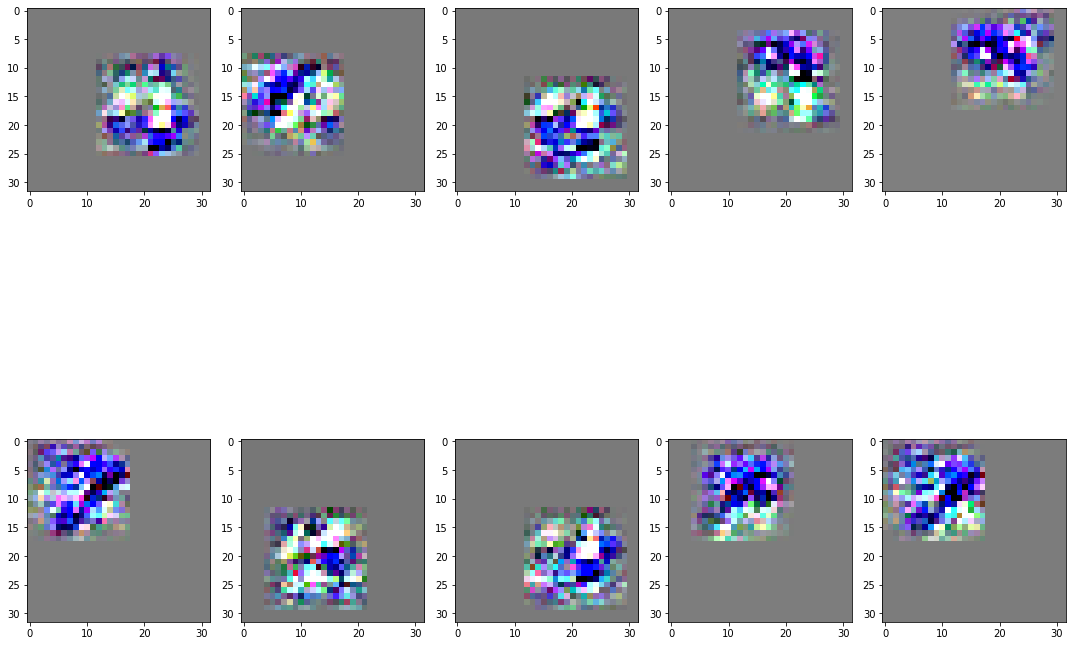

In [16]:

@tf.custom_gradient
#define the new gradient 
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad
#create a sub model upto the desired layer here it is cov_3 later 
gb_model = Model(
    inputs = [model.inputs],
    outputs = [model.get_layer("cov_3").output]
)
#find all layers which has activation as attribute 
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
#change the activation to guidedrelu
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu
#gradient tape to record the values to find gradient later
with tf.GradientTape(persistent=True) as tape:
  #taking the 0th image as input
  inputs = tf.cast(train_images[0].reshape([-1,32,32,3]), tf.float32)
  #watch the values of input
  tape.watch(inputs)
  #forward prop it through the sub model 
  outputs = gb_model(inputs)
  #to find out non zero entries
  zero = tf.constant(0, dtype=tf.float32)
  locations = tf.not_equal(outputs, zero)
  #find their indices
  indices = tf.where(locations)
  #create a tensor array for storing the layer with only the non zero neuron 
  ta = tf.TensorArray(tf.float32,size=0,dynamic_size=True)
  #sample 10 neurons from the non zero list of neuron indices 
  ind_set=random.sample(range(0,len(indices)),10)
  #loop through the indices set
  for i in ind_set:
    #create a zero matrix 
    z=np.zeros_like(outputs)
    #set the entry with index value same as that of the non zero neuron  
    z[tuple(indices[i].numpy())]=1
    #multiply this with the z matrix , we are doing this since we cant directly modify tensors
    #hence using elementwise multiplication with zero matrix as a work around 
    #write it to the array 
    ta=ta.write(i,tf.math.multiply(outputs,z))
#define a tensor array for gradients of each of these neurons 
tg=tf.TensorArray(tf.float32,size=0,dynamic_size=True,clear_after_read=False)
#for each of the neurons find the gradient 
for i in ind_set:
  tg= tg.write(i,tape.gradient(ta.read(i),inputs)[0])
#plotting 
#plt.imshow((np.array(grads)))
fig=plt.figure(figsize=(15, 15))
columns = 5
rows = 2
#fig.subplots_adjust(hspace=0.2)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.flip(deprocess_image(np.array(tg.read(ind_set[i-1]))),-1))
plt.tight_layout() 
plt.show()

